Importing necessary libraries

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix



In [75]:
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [76]:
df = pd.read_csv("spam.csv", encoding="latin-1")


In [77]:
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

In [78]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

Visualising Ham Vs Spam Distribution

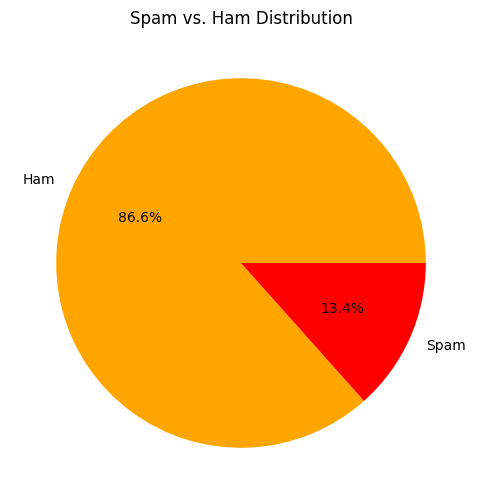

In [79]:
plt.figure(figsize=(6,6))
df['label'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Ham', 'Spam'], colors=['orange', 'red'])
plt.title('Spam vs. Ham Distribution')
plt.ylabel('')
plt.show()

Text Preprocessing

In [80]:
df.duplicated().values.any()

True

In [81]:
df.duplicated().sum()

403

In [82]:
df.drop_duplicates(inplace=True)

In [83]:
df.describe()

,label
count,5169.000000
mean,0.126330
std,0.332253
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [84]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = word_tokenize(text)

    # Custom stopword list - Do not remove words like "free", "winner", etc.
    spam_keywords = {'free', 'winner', 'win', 'prize', 'cash', 'congratulations', 'offer'}
    stop_words = set(stopwords.words('english')) - spam_keywords  # Remove stopwords except spam words

    words = [word for word in words if word not in stop_words]
    return ' '.join(words)


In [85]:
df['cleaned_message'] = df['message'].apply(preprocess_text)

# Convert text data to numerical vectors using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_message'])
y = df['label']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Initialising classifiers

In [87]:
nb_classifier = MultinomialNB(alpha=0.1)  # Lower alpha makes Naive Bayes more sensitive
logistic_classifier = LogisticRegression(class_weight='balanced', max_iter=500)  # Balance classes
svm_classifier = SVC(kernel='linear', probability=True, class_weight='balanced')  # Balance SVM

Training models

In [88]:
nb_classifier.fit(X_train, y_train)
logistic_classifier.fit(X_train, y_train)
rf_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear', probability=True)

In [89]:
models = {
    "Naive Bayes": nb_classifier,
    "Logistic Regression": logistic_classifier,
    "Random Forest": rf_classifier,
    "Support Vector Machine": svm_classifier
}

In [90]:
performance = {}
conf_matrices = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    performance[name] = [accuracy, precision, recall, f1]

    conf_matrices[name] = confusion_matrix(y_test, y_pred)

    print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")


Naive Bayes - Accuracy: 0.97, Precision: 0.89, Recall: 0.91, F1-score: 0.90
Logistic Regression - Accuracy: 0.97, Precision: 0.89, Recall: 0.90, F1-score: 0.89
Random Forest - Accuracy: 0.97, Precision: 0.99, Recall: 0.79, F1-score: 0.88
Support Vector Machine - Accuracy: 0.97, Precision: 0.92, Recall: 0.89, F1-score: 0.91


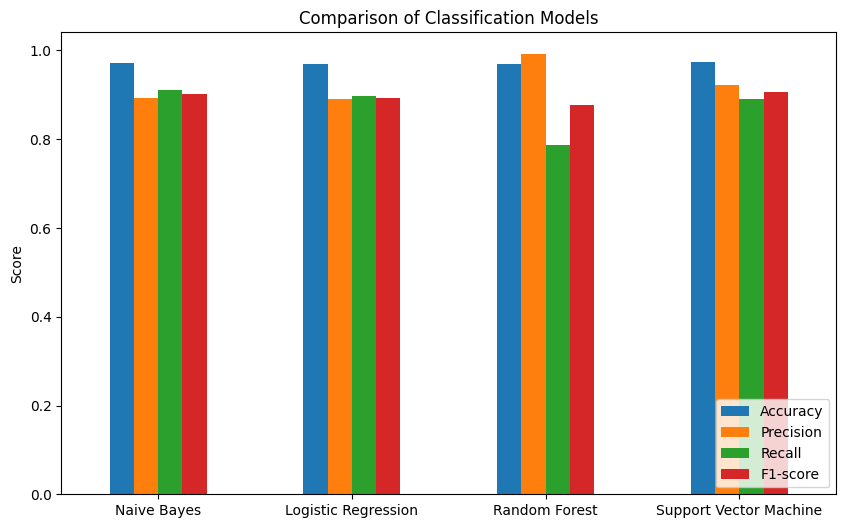

In [91]:
performance_df = pd.DataFrame(performance, index=['Accuracy', 'Precision', 'Recall', 'F1-score'])
performance_df.T.plot(kind='bar', figsize=(10,6))
plt.title("Comparison of Classification Models")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

Plotting confusion matrix

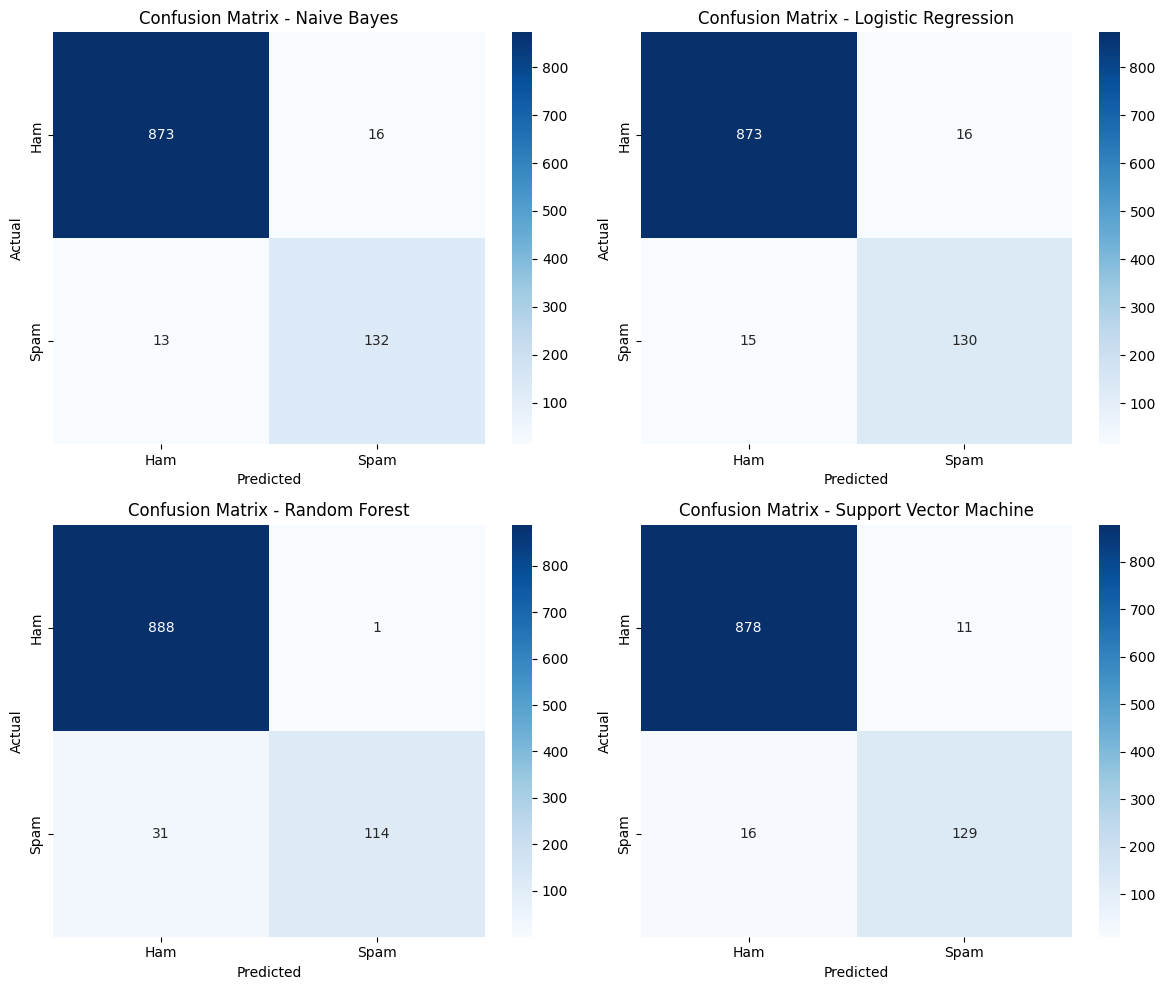

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, matrix) in zip(axes.flatten(), conf_matrices.items()):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'], ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

Predicting new messages

In [93]:
def predict_message(message):
    message_cleaned = preprocess_text(message)
    message_vectorized = vectorizer.transform([message_cleaned])
    predictions = {name: model.predict(message_vectorized)[0] for name, model in models.items()}
    return predictions

In [94]:
message = "Congratulations , You have won a free lottery ticket"
prediction_result = predict_message(message)
print("Predictions for the message:", prediction_result)

Predictions for the message: {'Naive Bayes': 1, 'Logistic Regression': 1, 'Random Forest': 0, 'Support Vector Machine': 1}
